In [1]:
import torch
import torch.fx as fx
import numpy as np
from torch.fx import symbolic_trace
from torch import nn
import torchvision
from torchvision import models
from torchvision import transforms
from PIL import Image
from scipy.stats import ttest_ind
import torch.optim as optim
import math
import torchvision
import pandas as pd
from numpy import array
from numpy.linalg import norm
from torch.optim import lr_scheduler
import seaborn as sns
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score

In [2]:
def get_few_shot_learing_data(_class, shot_number, trainloader):
    dataiter = iter(trainloader)
    _data = [ [] for i in range(len(_class))]
    _data_label = [ [] for i in range(len(_class))]

    for image, label in dataiter:
        

        if label in _class:
            ind = _class.index(label)
            if len(_data[ind])!=shot_number:
                _data[ind].append(image)
                _data_label[ind].append(label)

        if sum([len(tab) for tab in _data]) ==   shot_number * len(_class):
             break
    out_data= []
    out_label= [] 

    out_data_tensor = torch.Tensor(len(_class)*shot_number,3, 224, 224)
    out_label_tensor= torch.Tensor(len(_class)*shot_number)

    for i in range(len(_class)):
        for j in range(shot_number):
            out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
            out_label.append(torch.tensor(_data_label[i][j]).clone().detach()) 

    torch.cat(out_data , out=out_data_tensor)
    torch.cat(out_label , out=out_label_tensor)
    out_data_tensor=out_data_tensor.squeeze()
    out_label_tensor = out_label_tensor.type(torch.long)
    trainset_few_shot = out_data_tensor.squeeze(),out_label_tensor.squeeze()
    return trainset_few_shot


In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # remove for non-buggy env

In [4]:
class ATL(nn.Module):
    def __init__(self, train, Nlayer=3):
        # call constructor from superclass
        Nclasses = len(np.unique(train[1]))
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.relu = nn.ReLU()
        layers, R_scores_for_layers = self.get_layers(train, Nlayer)
        k = sns.lineplot(x=[i+1 for i in range(len(R_scores_for_layers))], y=R_scores_for_layers)
        k.set(ylim=(0, 1))
        plt.show()
        fm_indicies, resnet_out_size = self.get_featuremaps_idicies(train,layers, R_scores_for_layers) 
        self.resnet = self._transform( Nlayer, layers, fm_indicies)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.fcl = nn.Linear(resnet_out_size, Nclasses)
        self.softmax = torch.nn.Softmax(-1)
            
    def get_layers(self, train, number_of_layers):
        images, labels = train
        conv_layers, model_weights = self.get_resnet_conv_layers()
        feature_map_outputs_for_images = [self.get_feature_map_outputs(image) for image in images]
        labels_set = set(np.asarray(labels))
        
        R_scores_for_layers = []
        r_mean=[]
        r_max=[]
        for conv_ind in range(len(conv_layers)):
            
            centroids_for_class =[]
            LAV_vec = []             
                                
            for image_ind, image in enumerate(images):
                LAV_vec_image = []
                out_fm = feature_map_outputs_for_images[image_ind]
                for fm_ind in range(len(model_weights[conv_ind])):
                    LAV_vec_image.append(self.LAV(out_fm[conv_ind][fm_ind])) ##lav_vec jest vectorem przyjmującym lav dla każdego obrazka
                LAV_vec.append(LAV_vec_image)
            
              
                #iterujemy po klasach w danych
            for class_id, _class in enumerate(labels_set):
                    LAV_vec_curent_class = []
                    for i,fm in enumerate(LAV_vec):
                        if labels[i]==_class:
                            LAV_vec_curent_class.append(fm)
                    
                    n = len(LAV_vec_curent_class)
                    suma = np.asarray([0.0]*len(LAV_vec_curent_class[0]))
                    for k in range(n):
                        norm_l2 = norm(LAV_vec_curent_class[k])
                        nmn = np.asarray(LAV_vec_curent_class[k])/norm_l2
                        suma += nmn
                    centroid = 1/n * suma
                    centroids_for_class.append(centroid)
            
            #R-score
            r_val = []
            for a in range(len(centroids_for_class)-1):
                for b in range(a+1, len(centroids_for_class)):
                    rrrr = np.linalg.norm(centroids_for_class[a]-centroids_for_class[b], ord=1)
                    r_val.append(rrrr)
            R = min(r_val)
            R2 = np.mean(r_val)
            R3 = max(r_val)
            R_scores_for_layers.append(R)
            r_mean.append(R2)
            r_max.append(R3)
        # choosing the best n layers
        lst = pd.Series(R_scores_for_layers)
        i = lst.nlargest(number_of_layers)
        
        
        
        x = [i for i in range(len(R_scores_for_layers))]
        plt.plot(x,R_scores_for_layers, 'r')
        plt.plot(x,r_mean, 'b')
        plt.plot(x,r_max, 'y')
        plt.show()
        #print("wybrane warstwy: ",i.index.values.tolist())
        return sorted(i.index.values.tolist()), R_scores_for_layers 
        
    def get_featuremaps_idicies(self, train, layers,R,Pmax = 0.4):
        Rmax = max(R)
        dim0=[112]
        dim1=[56]*10
        dim2=[28]*12
        dim3=[14]*18
        dim4=[7]*8
        fm_dim = np.concatenate((dim0,dim1,dim2,dim3,dim4))        
        images, labels = train
        #print(labels)
        labels_set = set(np.asarray(labels))                
        conv_layers,model_weights = self.get_resnet_conv_layers()    
        choose_fm = []
        choose_fm_output_len=0        
        
        feature_map_outputs_for_images = [self.get_feature_map_outputs(image) for image in images]
             
                
        # iteruje po warstwach konwolucyjnuch 
        #print(layers)
        for conv_ind in layers:
            choose_fm_curent_conv_layer = []            
            p_score_for_classs_and_maps  = [([],[]) for i in range(len(labels_set))]
            
            # iteruje po mapach             
            for fm_ind in range(len(model_weights[conv_ind])):                
                LAV_vec = []
                    
                for image_ind,image in enumerate(images):
                    out_fm = feature_map_outputs_for_images[image_ind]
                    LAV_vec.append(self.LAV(out_fm[conv_ind][fm_ind]))
                 
                #iterujemy po klasach w danych
                for class_id, _class in enumerate(labels_set):
                    LAV_vec_curent_class = []
                    LAV_vec_other_class = []
                    for i,fm in enumerate(LAV_vec):
                        if labels[i]==_class:
                            LAV_vec_curent_class.append(fm)
                        else:     
                            LAV_vec_other_class.append(fm)
                    
                    # zwraca nan przy LAV_vec_current_class długości 1 !!
                    # czyli wtedy gdy z jakiejś klasy była tylko jedna obserwacja
                    # przy treningu nie będzie takiej sytucji
                    t_stat, p = ttest_ind(LAV_vec_curent_class, LAV_vec_other_class, equal_var=False)
                    p_treshold = Pmax * R[conv_ind]/Rmax
                    
                    if(math.isnan(p)): 
                        p=1
                    
                    
                    _tuple = p_score_for_classs_and_maps[class_id]
                    _tuple[0].append(p)
                    _tuple[1].append(fm_ind)
            
            # N_feature - minimum z liczby map wybranuch dla danej klasy
            #number_of_map_for_classes = [len(d) for d in  p_score_for_classs_and_maps]    
            number_of_map_for_classes = [len(d[0]) for d in  p_score_for_classs_and_maps]  
            N_feature = int(15/len(labels_set)+2)
            
            
            #print("N_feature: ", N_feature)
            #print("conv_ind: ", conv_ind)
            for class_id, p_scores_and_map_indexes in enumerate(p_score_for_classs_and_maps):                 
                #wybranie N_feature, "najlepszych" map dla każdej klasy" 
                
                
                #print("class_id ", class_id)
                
                #print("p < treshold  all",p_scores_and_map_indexes[0] )
                #print("map index p < treshold all",p_scores_and_map_indexes[1] )
                
                p_scores = np.asarray(p_scores_and_map_indexes[0]) 
                
                low_p_scores = p_scores.argsort()[:N_feature]
                
                for p_score in low_p_scores:
                    fm_ind = p_scores_and_map_indexes[1][p_score]
                    if fm_ind not in choose_fm_curent_conv_layer:
                        choose_fm_curent_conv_layer.append(fm_ind)
                        choose_fm_output_len += fm_dim[conv_ind]**2
                                        
            choose_fm.append(choose_fm_curent_conv_layer)
        
        
        #print (choose_fm)
        #print (choose_fm_output_len)
        
        # Musi zwracać obiekt który ma N iterowalnych rzeczy, z których każda ma ileś indeksów feature map. 
        # W sumie ilość indeksów musi być równa ilości klas * Nfeature z 2.3 w artykule
        #return [[1],[1]], 1568
        #print("wybrane mapy: ", choose_fm)
        #print("choose_fm_output_len", choose_fm_output_len)
        return choose_fm, choose_fm_output_len 
    
    
    def LAV(self,featureMap):
        return featureMap.max().detach().numpy().item(0)
    
    def _transform(self, n, layers, idx):
        gm = torch.fx.symbolic_trace(self.resnet)
        graph=gm.graph
        blocks_in_layers = [1,3,4,6,3]
        idx_to_layer_name = ['conv1'] +[f"layer{i}_{j}_conv{k}" for i in range(1,5) for j in range(blocks_in_layers[i]) for k in range(1,4)]
        layer_names = [idx_to_layer_name[idx] for idx in layers]
        final_nodes=[]
        last_node=None

        for node in graph.nodes:
            if node.name in layer_names:
                final_nodes.append(node)
            if not last_node and len(final_nodes)==n:
                last_node = node
            if node.name == 'output':
                out_node = node

        i=0
        nodes_to_output=[]
        for i in range(n):
            with graph.inserting_after(last_node):
            # Insert a new `call_function` node calling `torch.relu`
                new_node = graph.call_function(torch.tensor,
                                               args=(idx[i],),
                                              kwargs={"dtype":torch.int32})
                last_node = new_node

            with graph.inserting_after(last_node):
                new_node = graph.call_function(torch.index_select,
                                              args=(final_nodes[i], 1, last_node))
                last_node = new_node

            with graph.inserting_after(last_node):
                new_node = graph.call_function(torch.flatten,
                                              args=(last_node,1))
                nodes_to_output.append(new_node)
                last_node = new_node
        with graph.inserting_after(last_node):
                new_node = graph.call_function(torch.cat,
                                              args=(nodes_to_output,1))
        out_node.args=(new_node,)
        graph.eliminate_dead_code()
        graph.lint() 
        gm.recompile()
        return gm
        
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.relu(x)
        x = self.fcl(x)
        x = self.softmax(x)
        return x
    
    
    def get_resnet_conv_layers(self):
        model = self.resnet
        # we will save the conv layer weights in this list
        model_weights =[]

        #we will save the 49 conv layers in this list
        conv_layers = []

        # get all the model children as list
        model_children = list(model.children())

        #counter to keep count of the conv layers
        counter = 0
        #append all the conv layers and their respective wights to the list

        for i in range(len(model_children)):

            if type(model_children[i]) == nn.Conv2d:
                counter+=1
                model_weights.append(model_children[i].weight)
                conv_layers.append(model_children[i])

            elif type(model_children[i]) == nn.Sequential:
                for j in range(len(model_children[i])):
                    for child in model_children[i][j].children():
                        if type(child) == nn.Conv2d:
                            counter+=1
                            model_weights.append(child.weight)
                            conv_layers.append(child)

        #print(f"Total convolution layers: {counter}")
        #print("conv_layers")
        return (conv_layers,model_weights)
    
    def get_feature_map_outputs(self,image):
        conv_layers, _ = self.get_resnet_conv_layers()
        outputs = []
        names = []

        for layer in conv_layers[0:]:
            image = layer(image) #self.relu(layer(image))
            outputs.append(image)
            names.append(str(layer))
            
        #print(len(outputs))

        # print feature_maps
        #for feature_map in outputs:
            #print(feature_map.shape)
            
        return outputs;   



# CIFAR100 

# transform = transforms.Compose([                        #[1]
#              transforms.Resize(256),                    #[2]
#              transforms.CenterCrop(224),                #[3]
#              transforms.ToTensor(),                     #[4]
#              transforms.Normalize(                      #[5]
#              mean=[0.485, 0.456, 0.406],                #[6]
#              std=[0.229, 0.224, 0.225]                  #[7]
#              )])


# trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
#                                         download=True, transform=transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR100(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# torch.manual_seed(0)
# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# trainset = images, labels
# #print(trainset)

# print(images)
# print(labels)





In [5]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context # remove for non-buggy env

np.random.seed = 123
torch.manual_seed(0)

transform = transforms.Compose([transforms.Resize(224),
             transforms.ToTensor(),
             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), ])


trainset = torchvision.datasets.CIFAR100(root='./data',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=2)


Files already downloaded and verified


In [6]:


testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=6)



Files already downloaded and verified


C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
def train(_class,trainloader,testloader, shot_number = 10, shot_number_test = 100):
    acc=0
    #train
    trainset_few_shot = get_few_shot_learing_data(_class,shot_number,trainloader)
    inputs_train, labels_train = trainset_few_shot 
    labels = torch.tensor([_class.index(label) for label in labels_train])

    testset_few_shot = get_few_shot_learing_data(_class,shot_number_test,testloader)
    inputs_test, labels_test = testset_few_shot 
    labels_test = torch.tensor([_class.index(label) for label in labels_test])


    m= ATL(trainset_few_shot,3)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(m.parameters(),lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    import seaborn as sns
    from matplotlib import pyplot as plt
    for epoch in range(50):  # loop over the dataset multiple times

        running_loss = 0.0
        # get the inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = m(inputs_train)
        #print(outputs)
        #sns.heatmap(outputs.detach())
        #plt.show()
        #print(len(labels))
        #print(len(outputs))

        loss = criterion(outputs, labels)

        running_loss += loss.item()
        print(f'{epoch + 1} loss: {running_loss}')

        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch%10==9:
            out = m(inputs_test)
            y = torch.argmax(out, dim=1)
            #print(y)
            #print(accuracy_score(y,labelstest))
            #sns.heatmap(outputstest.detach())
            #plt.show()
            #print(labelstest)


            acc = max(acc, accuracy_score(y,labels_test))
    print(f'Finished Training {shot_number}')
    return acc

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())
C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please 

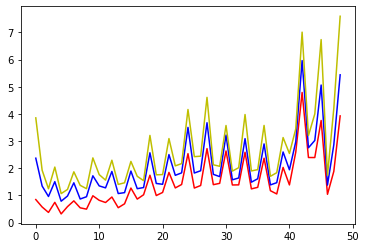

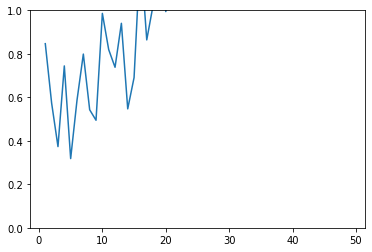

1 loss: 1.6092562675476074
2 loss: 1.55406653881073
3 loss: 1.4907244443893433
4 loss: 1.4212775230407715
5 loss: 1.3488820791244507
6 loss: 1.2772691249847412
7 loss: 1.2099754810333252
8 loss: 1.1497076749801636
9 loss: 1.0980607271194458
10 loss: 1.0555171966552734
11 loss: 1.0216177701950073
12 loss: 1.000073790550232
13 loss: 0.982753574848175
14 loss: 0.9689069986343384
15 loss: 0.9578607082366943
16 loss: 0.949043869972229
17 loss: 0.941989541053772
18 loss: 0.9363234639167786
19 loss: 0.9317511320114136
20 loss: 0.9280409216880798
21 loss: 0.9250129461288452
22 loss: 0.9229980111122131
23 loss: 0.9212889075279236
24 loss: 0.919831395149231
25 loss: 0.9185816049575806
26 loss: 0.9175044298171997
27 loss: 0.916571319103241
28 loss: 0.9157590866088867
29 loss: 0.9150487780570984
30 loss: 0.9144247770309448
31 loss: 0.913874089717865
32 loss: 0.9134818315505981
33 loss: 0.9131287336349487
34 loss: 0.9128101468086243
35 loss: 0.912521481513977
36 loss: 0.9122591018676758
37 loss: 0.

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())
C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please 

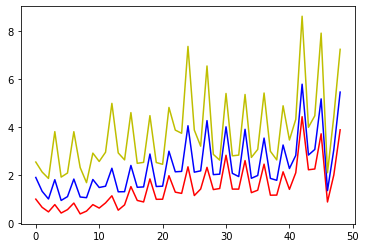

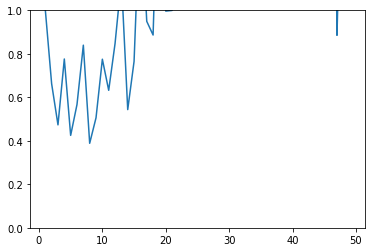

1 loss: 2.3023102283477783
2 loss: 2.263871431350708
3 loss: 2.2139854431152344
4 loss: 2.1520793437957764
5 loss: 2.079437255859375
6 loss: 1.9993928670883179
7 loss: 1.9166053533554077
8 loss: 1.8359020948410034
9 loss: 1.7613805532455444
10 loss: 1.6959607601165771
11 loss: 1.64118492603302
12 loss: 1.6052443981170654
13 loss: 1.5758885145187378
14 loss: 1.5523669719696045
15 loss: 1.5337880849838257
16 loss: 1.5192493200302124
17 loss: 1.5079286098480225
18 loss: 1.4991250038146973
19 loss: 1.4922674894332886
20 loss: 1.4869056940078735
21 loss: 1.482690691947937
22 loss: 1.4799790382385254
23 loss: 1.4777443408966064
24 loss: 1.47589111328125
25 loss: 1.4743443727493286
26 loss: 1.4730457067489624
27 loss: 1.4719483852386475
28 loss: 1.4710158109664917
29 loss: 1.4702186584472656
30 loss: 1.4695335626602173
31 loss: 1.4689414501190186
32 loss: 1.4685273170471191
33 loss: 1.46816086769104
34 loss: 1.467835545539856
35 loss: 1.4675449132919312
36 loss: 1.467284917831421
37 loss: 1.4

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())
C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please 

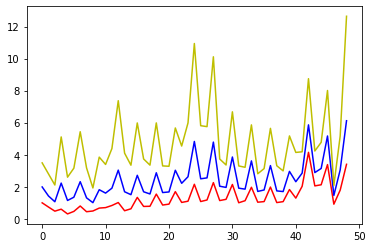

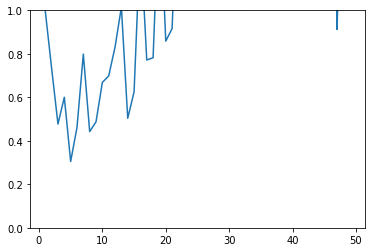

1 loss: 2.70817232131958
2 loss: 2.6669955253601074
3 loss: 2.6060972213745117
4 loss: 2.5223963260650635
5 loss: 2.4174787998199463
6 loss: 2.2996633052825928
7 loss: 2.1822333335876465
8 loss: 2.078056573867798
9 loss: 1.9949462413787842
10 loss: 1.9344165325164795
11 loss: 1.893286108970642
12 loss: 1.871068000793457
13 loss: 1.8556575775146484
14 loss: 1.8450076580047607
15 loss: 1.8376203775405884
16 loss: 1.8324487209320068
17 loss: 1.828781008720398
18 loss: 1.8261408805847168
19 loss: 1.8242098093032837
20 loss: 1.8227742910385132
21 loss: 1.8216909170150757
22 loss: 1.8210148811340332
23 loss: 1.8204714059829712
24 loss: 1.820029377937317
25 loss: 1.8196661472320557
26 loss: 1.819365382194519
27 loss: 1.8191142082214355
28 loss: 1.8189023733139038
29 loss: 1.8187227249145508
30 loss: 1.818569302558899
31 loss: 1.8184373378753662
32 loss: 1.8183454275131226
33 loss: 1.8182646036148071
34 loss: 1.8181934356689453
35 loss: 1.8181301355361938
36 loss: 1.8180737495422363
37 loss: 1

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())
C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please 

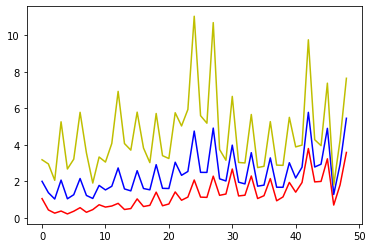

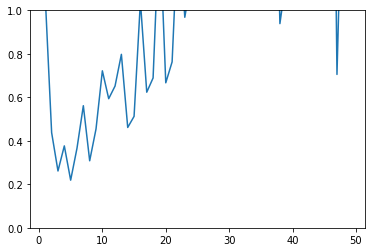

1 loss: 2.995762825012207
2 loss: 2.96886944770813
3 loss: 2.9296951293945312
4 loss: 2.8751494884490967
5 loss: 2.8034849166870117
6 loss: 2.7158119678497314
7 loss: 2.6169216632843018
8 loss: 2.514296293258667
9 loss: 2.4161083698272705
10 loss: 2.3293566703796387
11 loss: 2.258390188217163
12 loss: 2.213831901550293
13 loss: 2.179356575012207
14 loss: 2.153470277786255
15 loss: 2.134424924850464
16 loss: 2.1205642223358154
17 loss: 2.110504627227783
18 loss: 2.1031789779663086
19 loss: 2.0978052616119385
20 loss: 2.093823194503784
21 loss: 2.090839147567749
22 loss: 2.0889933109283447
23 loss: 2.087519645690918
24 loss: 2.086331844329834
25 loss: 2.0853655338287354
26 loss: 2.0845720767974854
27 loss: 2.0839152336120605
28 loss: 2.0833675861358643
29 loss: 2.0829074382781982
30 loss: 2.082517385482788
31 loss: 2.082185745239258
32 loss: 2.081956624984741
33 loss: 2.081756114959717
34 loss: 2.0815796852111816
35 loss: 2.0814239978790283
36 loss: 2.0812864303588867
37 loss: 2.08116340

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())
C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please 

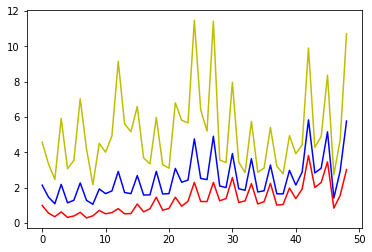

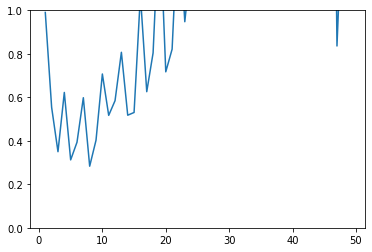

1 loss: 3.2189035415649414
2 loss: 3.189173936843872
3 loss: 3.1411118507385254
4 loss: 3.068812608718872
5 loss: 2.9699366092681885
6 loss: 2.8500218391418457
7 loss: 2.7224247455596924
8 loss: 2.602574348449707
9 loss: 2.5024547576904297
10 loss: 2.4273974895477295
11 loss: 2.3757882118225098
12 loss: 2.34792423248291
13 loss: 2.3287768363952637
14 loss: 2.3157994747161865
15 loss: 2.3070452213287354
16 loss: 2.3011176586151123
17 loss: 2.2970614433288574
18 loss: 2.2942428588867188
19 loss: 2.2922496795654297
20 loss: 2.29081392288208
21 loss: 2.2897603511810303
22 loss: 2.289118766784668
23 loss: 2.288612127304077
24 loss: 2.2882070541381836
25 loss: 2.287879705429077
26 loss: 2.287612199783325
27 loss: 2.2873916625976562
28 loss: 2.28720760345459
29 loss: 2.287053346633911
30 loss: 2.2869229316711426
31 loss: 2.2868118286132812
32 loss: 2.2867355346679688
33 loss: 2.286668062210083
34 loss: 2.286609649658203
35 loss: 2.286557674407959
36 loss: 2.2865116596221924
37 loss: 2.2864711

C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_data.append(torch.tensor(_data[i][j]).clone().detach().unsqueeze(0))
C:\Users\Grzegorz Kiersnowski\AppData\Local\Temp\ipykernel_12932\292393638.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_label.append(torch.tensor(_data_label[i][j]).clone().detach())
C:\PYTHON\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please 

KeyboardInterrupt: 

In [11]:
import random
dic={}
for shot_number in [3, 5, 10]:
    for way_number in [5, 10, 15, 20, 25, 30]:
        _class = random.sample([i for i in range(100)], way_number)

        acc=train(_class,trainloader,testloader,shot_number = shot_number, shot_number_test = 100)
        print(f"accuracy for {way_number} classes each of {shot_number} samples: {acc}")
        dic[f"samp_{shot_number}_class_{way_number}"]=acc

In [12]:
dic

{'samp_3_class_5': 0.586,
 'samp_3_class_10': 0.323,
 'samp_3_class_15': 0.396,
 'samp_3_class_20': 0.3965,
 'samp_3_class_25': 0.3304}

### PCAM

In [ ]:
trainsetPCAM = torchvision.datasets.PCAM(root='./data', split = 'train',download=True, transform=transform)
trainloaderPCAM = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=2)

_class = [0,1]

In [ ]:
valsetPCAM = torchvision.datasets.PCAM(root='./data',split = 'val',download=True, transform=transform)
valloaderPCAM = torch.utils.data.DataLoader(valsetPCAM, batch_size=1,
                                          shuffle=False, num_workers=2)



In [ ]:
testsetPCAM = torchvision.datasets.PCAM(root='./data',split = 'test',download=True, transform=transform)
testloaderPCAM = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)






In [ ]:
def pcam_train(shot_number = 10, shot_number_test = 100):
    _class = [0,1]
    acc=0
    #train
    trainset_few_shot_pcamp = get_few_shot_learing_data(_class,shot_number,trainloaderPCAM)

    testset_few_shot_pcamp = get_few_shot_learing_data(_class,shot_number_test,testloaderPCAM)
    inputstest, labelstest = testset_few_shot_pcamp
    m_pcam = ATL(trainset_few_shot_pcamp,3)


    # trenowanie 
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(m_pcam.parameters(),lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    import seaborn as sns
    from matplotlib import pyplot as plt
    for epoch in range(50):  # loop over the dataset multiple times



        running_loss = 0.0
        # get the inputs
        inputs, labels = trainset_few_shot_pcamp #data


        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = m_pcam(inputs)
        #print(outputs)
        #sns.heatmap(outputs.detach())
        #plt.show()
        #print(len(labels))
        #print(len(outputs))



        loss = criterion(outputs, labels)

        running_loss += loss.item()
        print(f'{epoch + 1} loss: {running_loss}')

        loss.backward()
        optimizer.step()

        # print statistics

    #     print('[%d] loss: %.3f' %
    #         (epoch + 1, running_loss / 25))


        scheduler.step()



        if epoch%10==9:
            outputstest = m_pcam(inputstest)
            y = torch.argmax(outputstest, dim=1)
            #print(y)
            #print(accuracy_score(y,labelstest))
            #sns.heatmap(outputstest.detach())
            #plt.show()
            #print(labelstest)
            acc = max(acc, accuracy_score(y,labelstest))
    print(f'Finished Training {shot_number} with acc of {acc}')
    return acc

In [ ]:
labels

In [ ]:
#test
testset_few_shot_pcamp = get_few_shot_learing_data(_class,shot_number,testloaderPCAM)
inputs, labels = testset_few_shot_pcamp
outputs = m_pcam(inputs)
#print(outputs)
y = torch.argmax(outputs, dim=1)

print("accuracy_score")
accuracy_score(y,labels)

In [ ]:
t={}
for shot_number in [3,5,10,20,50,100]:   
    t[shot_number]=pcam_train(shot_number,100)

In [ ]:
t

In [ ]:
names = list(t.keys())
values = list(t.values())

plt.bar(range(len(t)), values, tick_label=names, color="y")
plt.title("PCAM accuracy")
plt.ylabel("accuracy")
plt.xlabel("number of samples from each class")
plt.savefig("PCAM_ACC.png")